In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
import itertools
import math
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, ZeroPadding2D, Input
from keras.models import Model
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.applications.resnet50 import ResNet50
import cv2
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

pd.set_option("display.max_rows", 6)

np.random.seed(2)

Using TensorFlow backend.


(1, 333, 500, 3)

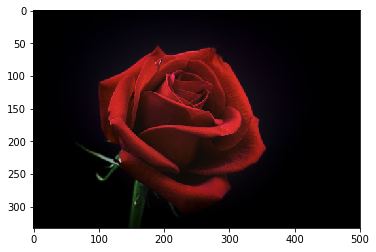

In [2]:
from PIL import Image
im = Image.open("carlos-quintero-565901-unsplash.jpg")
image = np.array(im)/255

plt.imshow(image)
images = np.expand_dims(image, axis=0)
images.shape

In [3]:
model = Sequential()
model.add(Conv2D(4, (3,3), kernel_initializer='he_uniform'))
model.compile(optimizer='sgd')
model.build()
#model.summary()

In [4]:
p = model.predict(images)
p.shape

(1, 331, 498, 4)

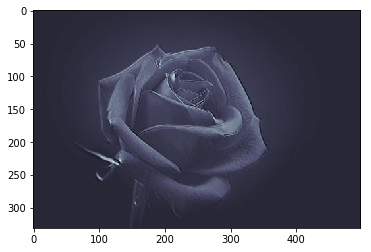

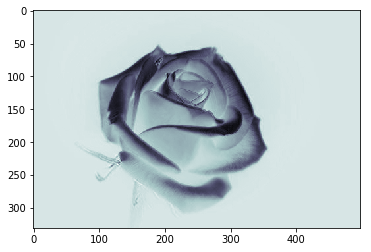

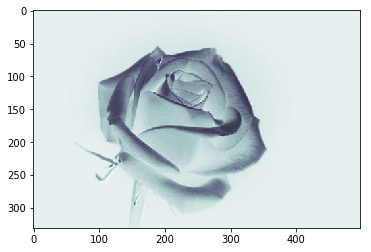

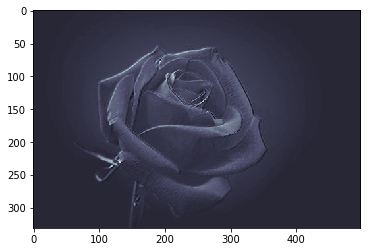

In [5]:
for i in range(p.shape[3]):
    plt.imshow(p[0, :, :, i], cmap='bone')
    plt.show()


In [6]:
batch_size = 128

datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True, validation_split=0.2)

train_generator = datagen.flow_from_directory(
        'input/train',
        subset='training',
        target_size=(224, 224),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
)
val_generator = datagen.flow_from_directory(
        'input/train',
         subset='validation',
        target_size=(224, 224),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [69]:

inp = Input(shape=(224,224,1))
x = Conv2D(128, (3,3), strides=(2,2), name='conv4')(inp)
x = Conv2D(128, (3,3), name='conv6')(x)
x = MaxPool2D(2,2)(x)
x = Dropout(.2)(x)
x = Conv2D(256, (3,3), strides=(2,2), name='conv8')(x)
x = Conv2D(256, (3,3), name='conv9')(x)
x = MaxPool2D(2,2)(x)
x = Conv2D(512, (3,3), strides=(2,2), name='conv10')(x)
x = Conv2D(512, (3,3), name='conv12')(x)
x = MaxPool2D(2,2)(x)
x = Dropout(.2)(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(2, activation='softmax')(x)
model = Model(inp, x)




In [70]:

from keras.optimizers import SGD

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 224, 224, 1)       0         
_________________________________________________________________
conv4 (Conv2D)               (None, 111, 111, 128)     1280      
_________________________________________________________________
conv6 (Conv2D)               (None, 109, 109, 128)     147584    
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 54, 54, 128)       0         
_________________________________________________________________
dropout_65 (Dropout)         (None, 54, 54, 128)       0         
_________________________________________________________________
conv8 (Conv2D)               (None, 26, 26, 256)       295168    
_________________________________________________________________
conv9 (Conv2D)               (None, 24, 24, 256)       590080    
__________

In [ ]:

# fits the model on batches with real-time data augmentation:
model.fit_generator(train_generator, 
                    validation_data=val_generator,
                    steps_per_epoch=len(train_generator.classes)/batch_size, 
                    validation_steps=len(val_generator.classes)/batch_size,
                    epochs=10)


Epoch 1/10


In [73]:
model.save('catsdogs1.h5')

In [74]:
layer_outputs = [layer.output for layer in model.layers[1:12]] 
# Extracts the outputs of the top 12 layers
activation_model = Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
#activation_model.compile(optimizer='sgd', loss='categorical_crossentropy')

(224, 224, 1)


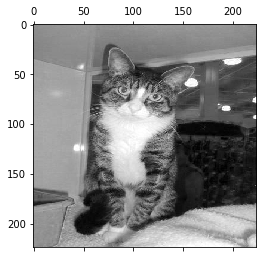

In [75]:
im = Image.open("input/train/cat/cat.34.jpg")
image = np.array(im.resize((224,224)))/255
image = np.reshape(image[:,:,0], (224,224,1))
plt.matshow(image[:,:,0], cmap='gray')
print(image.shape)


(1, 224, 224, 1)
(1, 111, 111, 128)


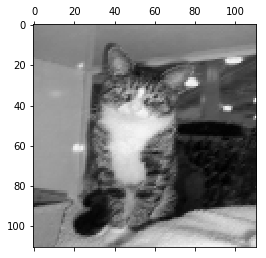

In [76]:

#plt.imshow(image)
images = np.expand_dims(image, axis=0)
print(images.shape)

activations = activation_model.predict(images) 

first_layer_activation = activations[0]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0, :, :, 4], cmap='gray')


/home/daniele/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


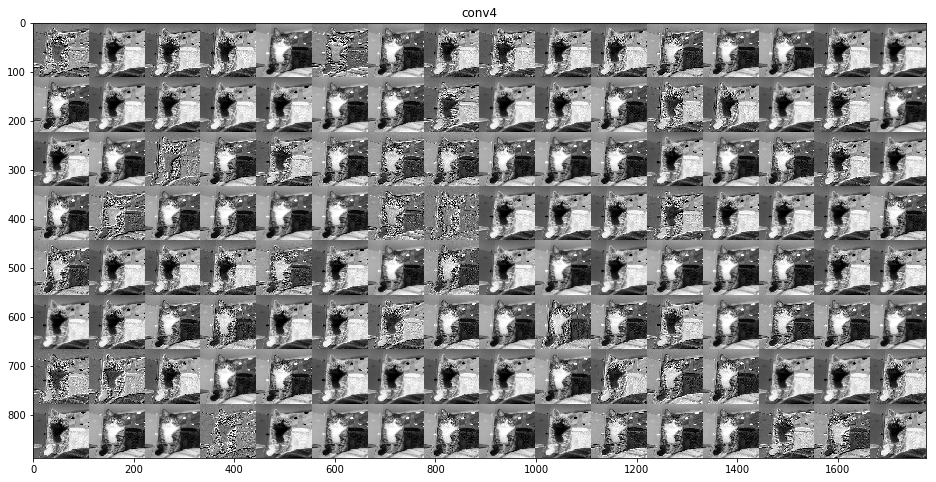

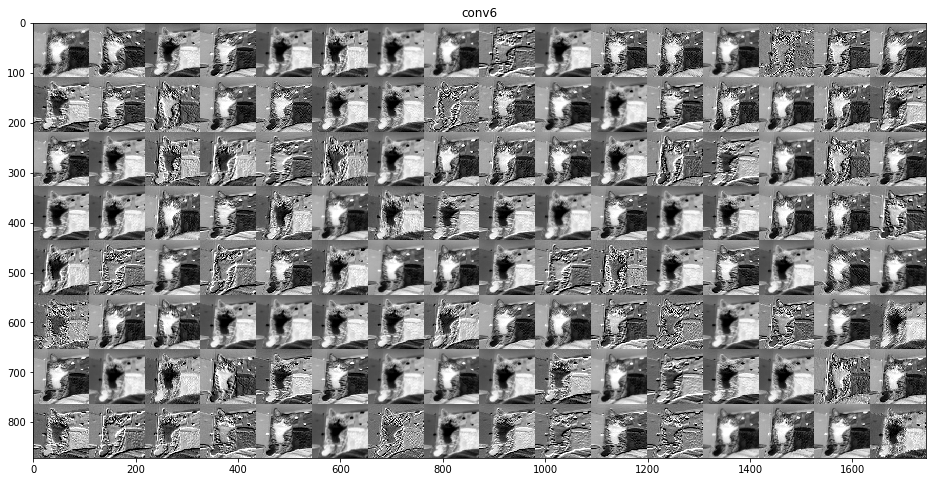

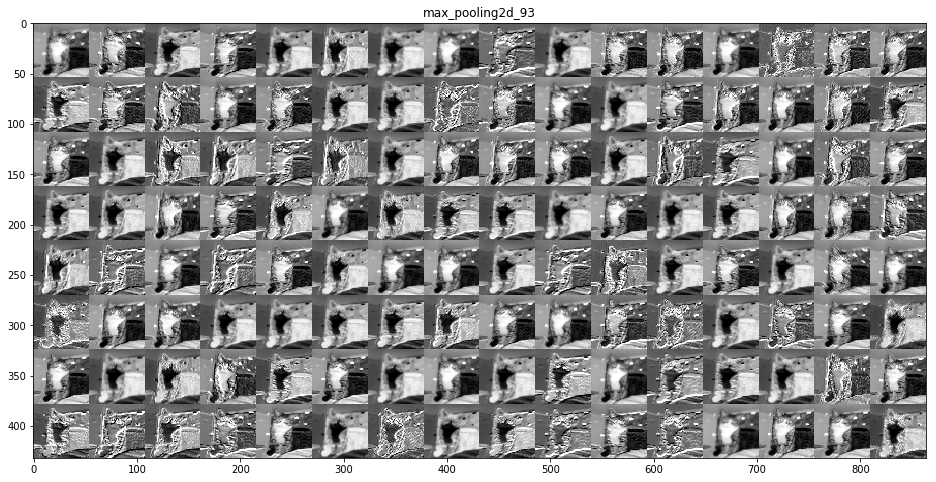

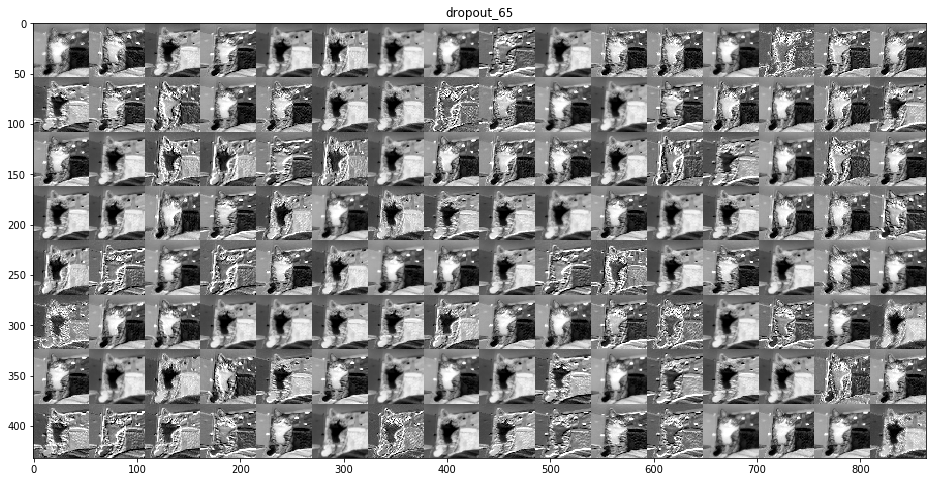

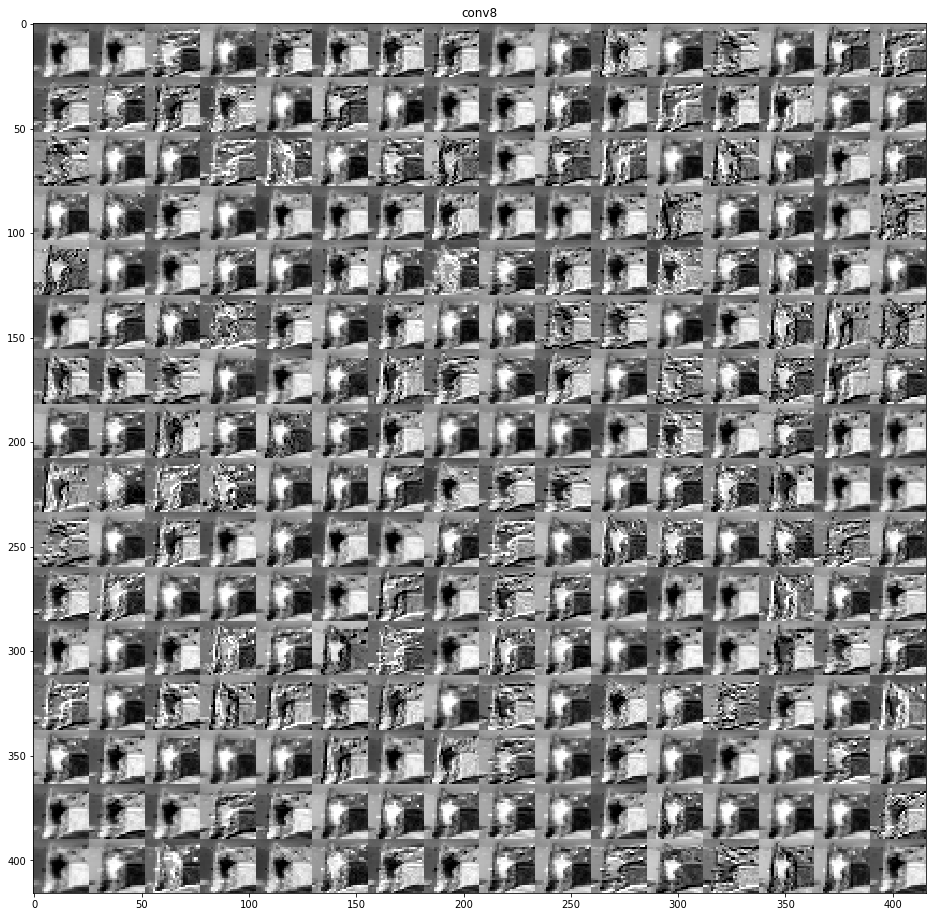

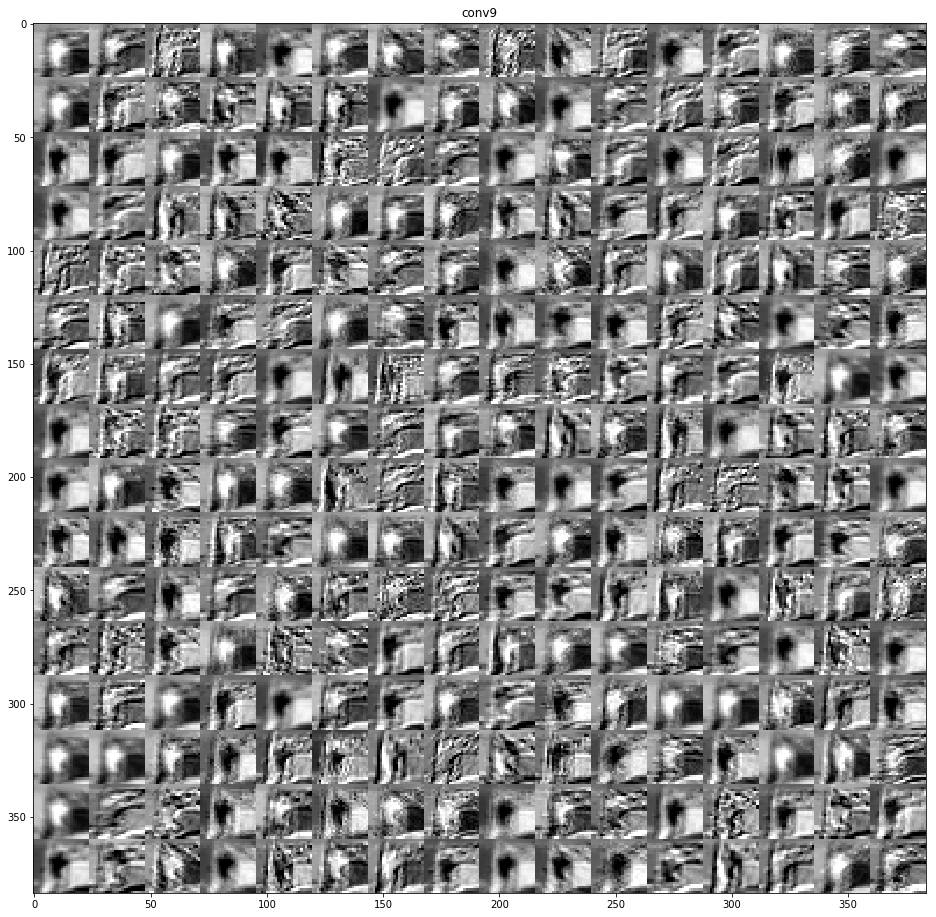

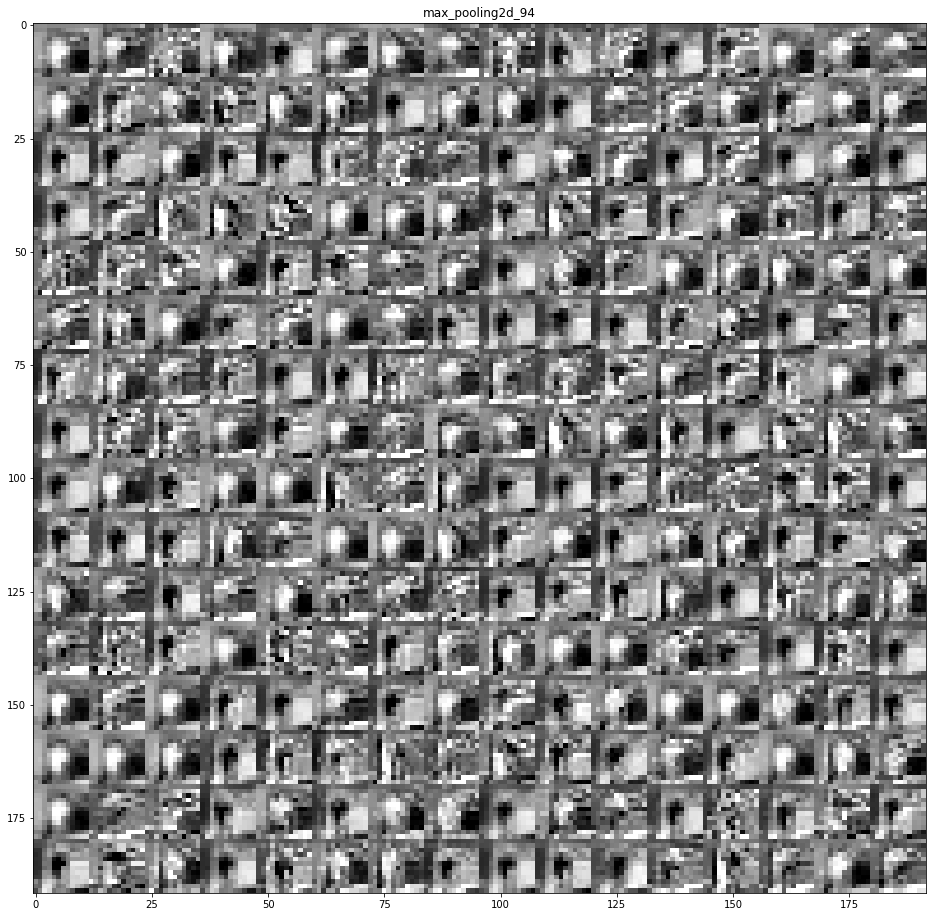

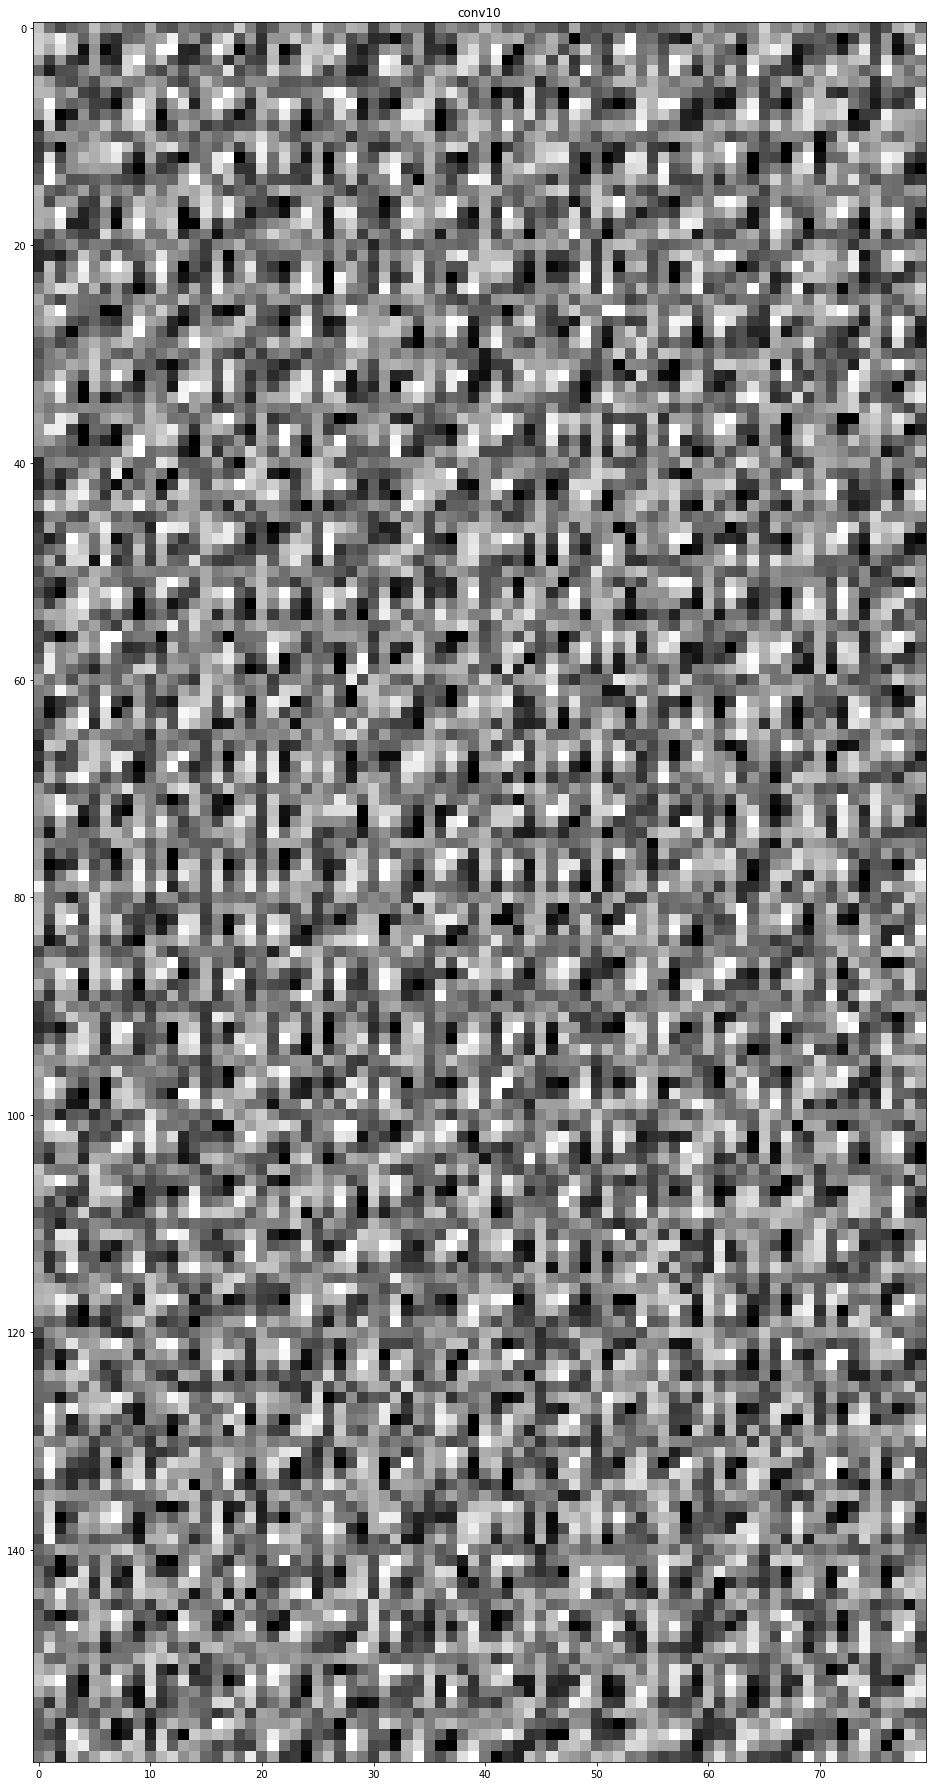

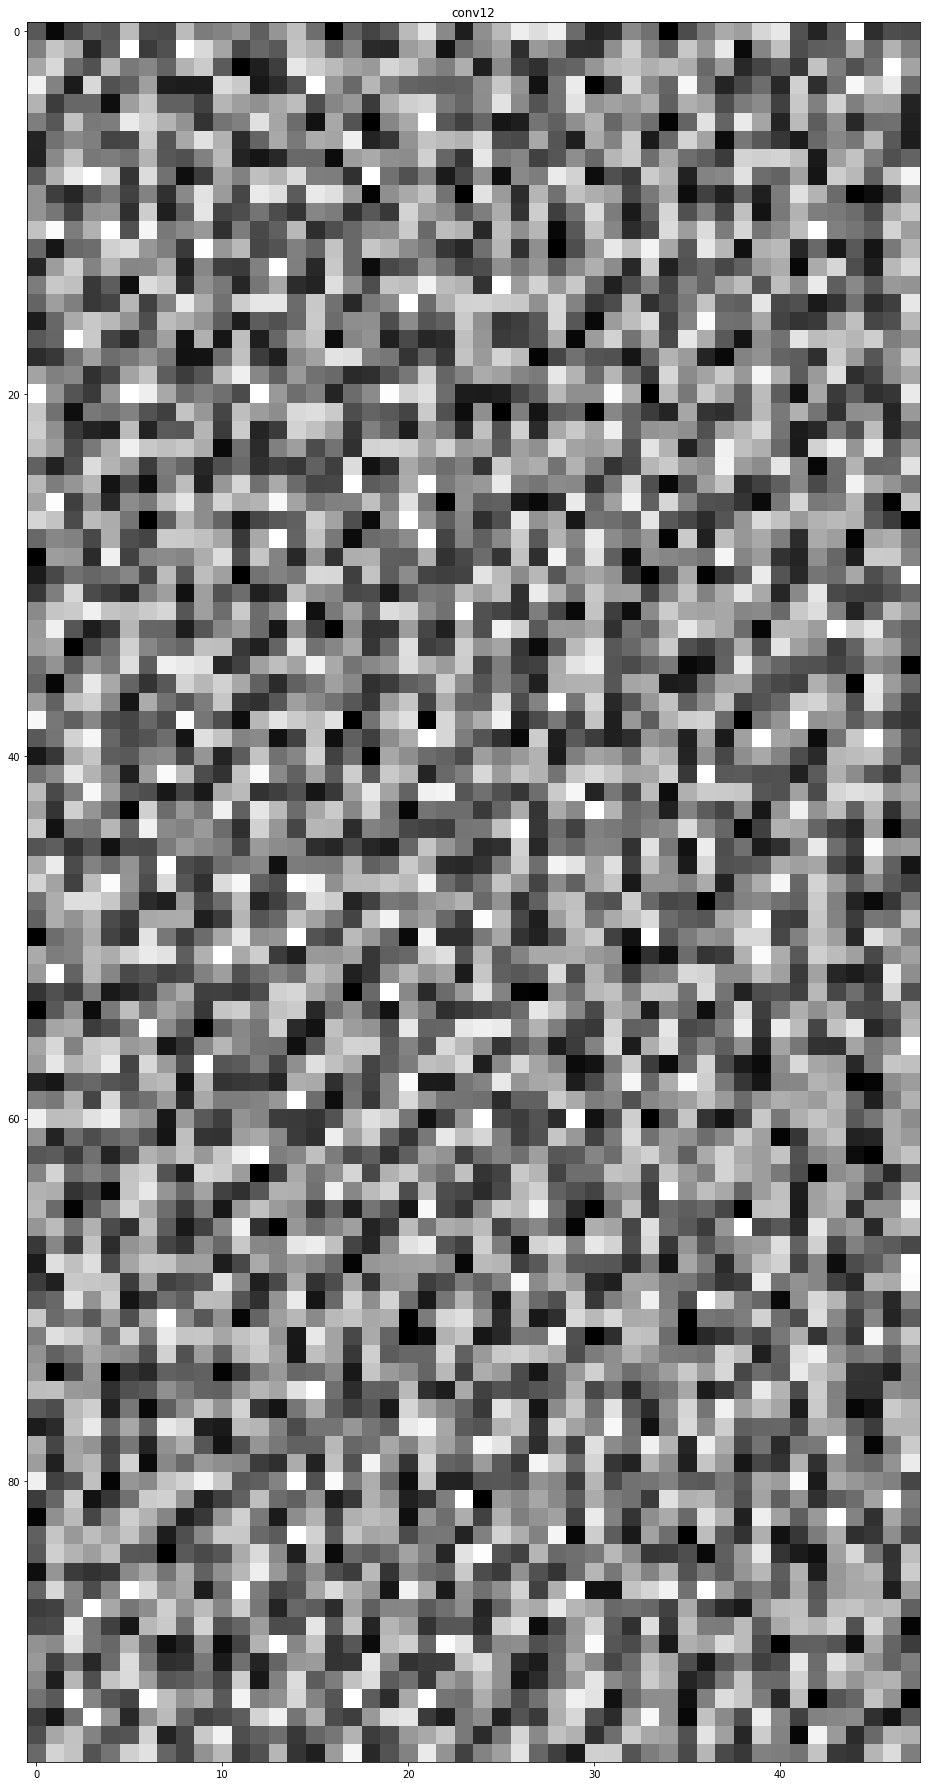

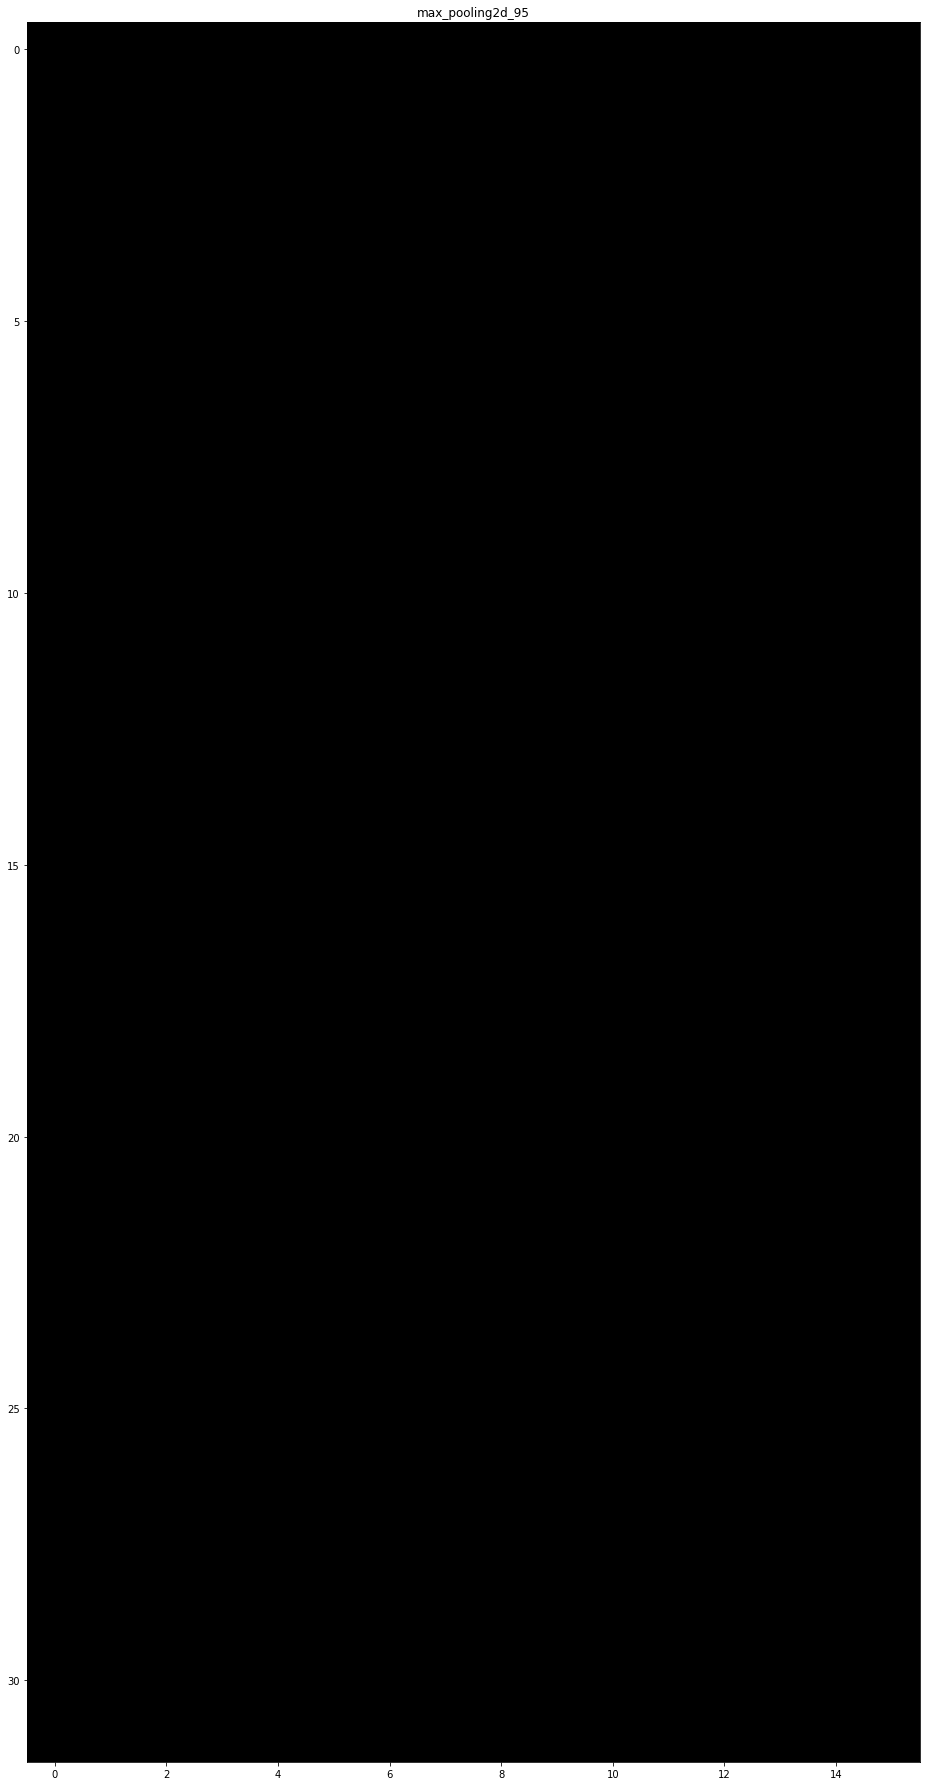

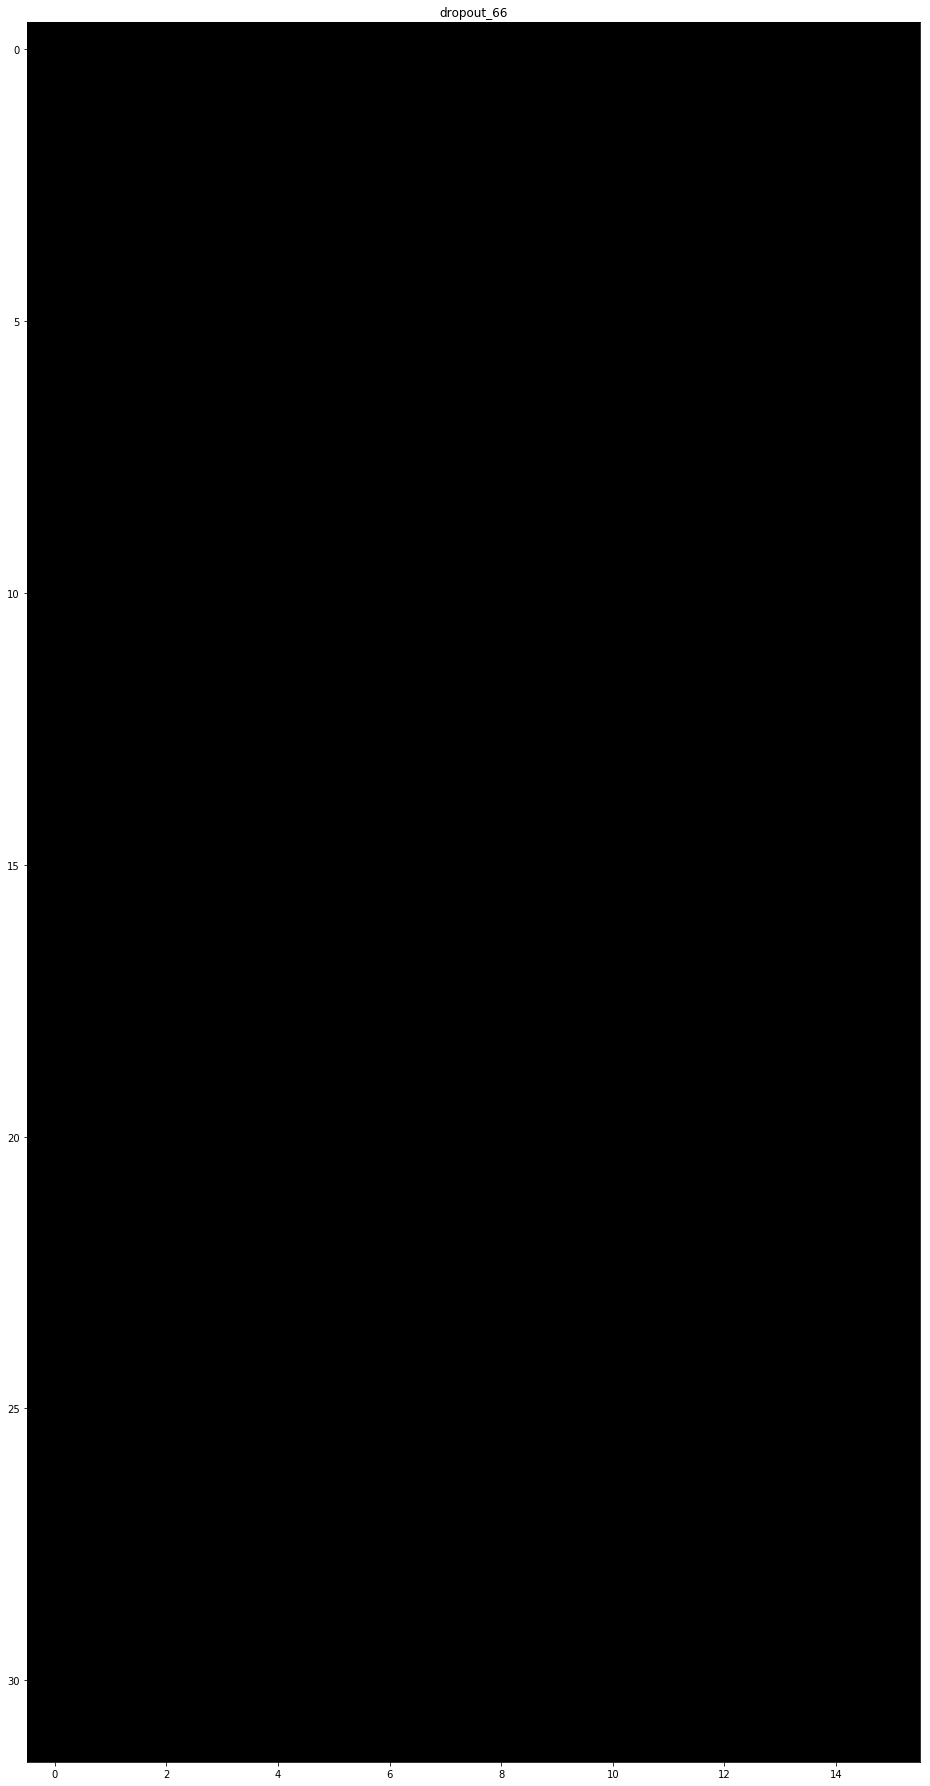

In [77]:
layer_names = []
for layer in model.layers[1:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')
